# Traffic Vehicle Prediction - ML Project

## Dataset Information
- **48,120 observations** of vehicle count per hour at 4 different junctions
- **Features**: DateTime, Junction, Vehicles, ID
- **Objective**: Predict the number of vehicles (Regression Problem)

## 1. Import Libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# ML libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Regression algorithms
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Raw Data

In [2]:
# Load the dataset
df = pd.read_csv('traffic.csv')

print("Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print("\nFirst few rows:")
df.head(10)

Dataset loaded successfully!
Shape: (48120, 4)

First few rows:


,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041
5,2015-11-01 05:00:00,1,6,20151101051
6,2015-11-01 06:00:00,1,9,20151101061
7,2015-11-01 07:00:00,1,8,20151101071
8,2015-11-01 08:00:00,1,11,20151101081
9,2015-11-01 09:00:00,1,12,20151101091


## 3. Exploratory Data Analysis (EDA)

In [3]:
# Basic information about the dataset
print("="*50)
print("DATASET INFORMATION")
print("="*50)
print(df.info())
print("\n" + "="*50)
print("STATISTICAL SUMMARY")
print("="*50)
print(df.describe())
print("\n" + "="*50)
print("DATA TYPES")
print("="*50)
print(df.dtypes)

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48120 entries, 0 to 48119
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  48120 non-null  object
 1   Junction  48120 non-null  int64 
 2   Vehicles  48120 non-null  int64 
 3   ID        48120 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None

STATISTICAL SUMMARY
           Junction      Vehicles            ID
count  48120.000000  48120.000000  4.812000e+04
mean       2.180549     22.791334  2.016330e+10
std        0.966955     20.750063  5.944854e+06
min        1.000000      1.000000  2.015110e+10
25%        1.000000      9.000000  2.016042e+10
50%        2.000000     15.000000  2.016093e+10
75%        3.000000     29.000000  2.017023e+10
max        4.000000    180.000000  2.017063e+10

DATA TYPES
DateTime    object
Junction     int64
Vehicles     int64
ID           int64
dtype: object


In [4]:
# Check for null values and unique values
print("="*50)
print("NULL VALUES CHECK")
print("="*50)
print(df.isnull().sum())
print(f"\nTotal null values: {df.isnull().sum().sum()}")

print("\n" + "="*50)
print("UNIQUE VALUES COUNT")
print("="*50)
for col in df.columns:
    print(f"{col}: {df[col].nunique()} unique values")
    
print("\n" + "="*50)
print("JUNCTIONS IN DATASET")
print("="*50)
print(df['Junction'].value_counts().sort_index())

NULL VALUES CHECK
DateTime    0
Junction    0
Vehicles    0
ID          0
dtype: int64

Total null values: 0

UNIQUE VALUES COUNT
DateTime: 14592 unique values
Junction: 4 unique values
Vehicles: 141 unique values
ID: 48120 unique values

JUNCTIONS IN DATASET
Junction
1    14592
2    14592
3    14592
4     4344
Name: count, dtype: int64


### 3.1 Data Visualizations

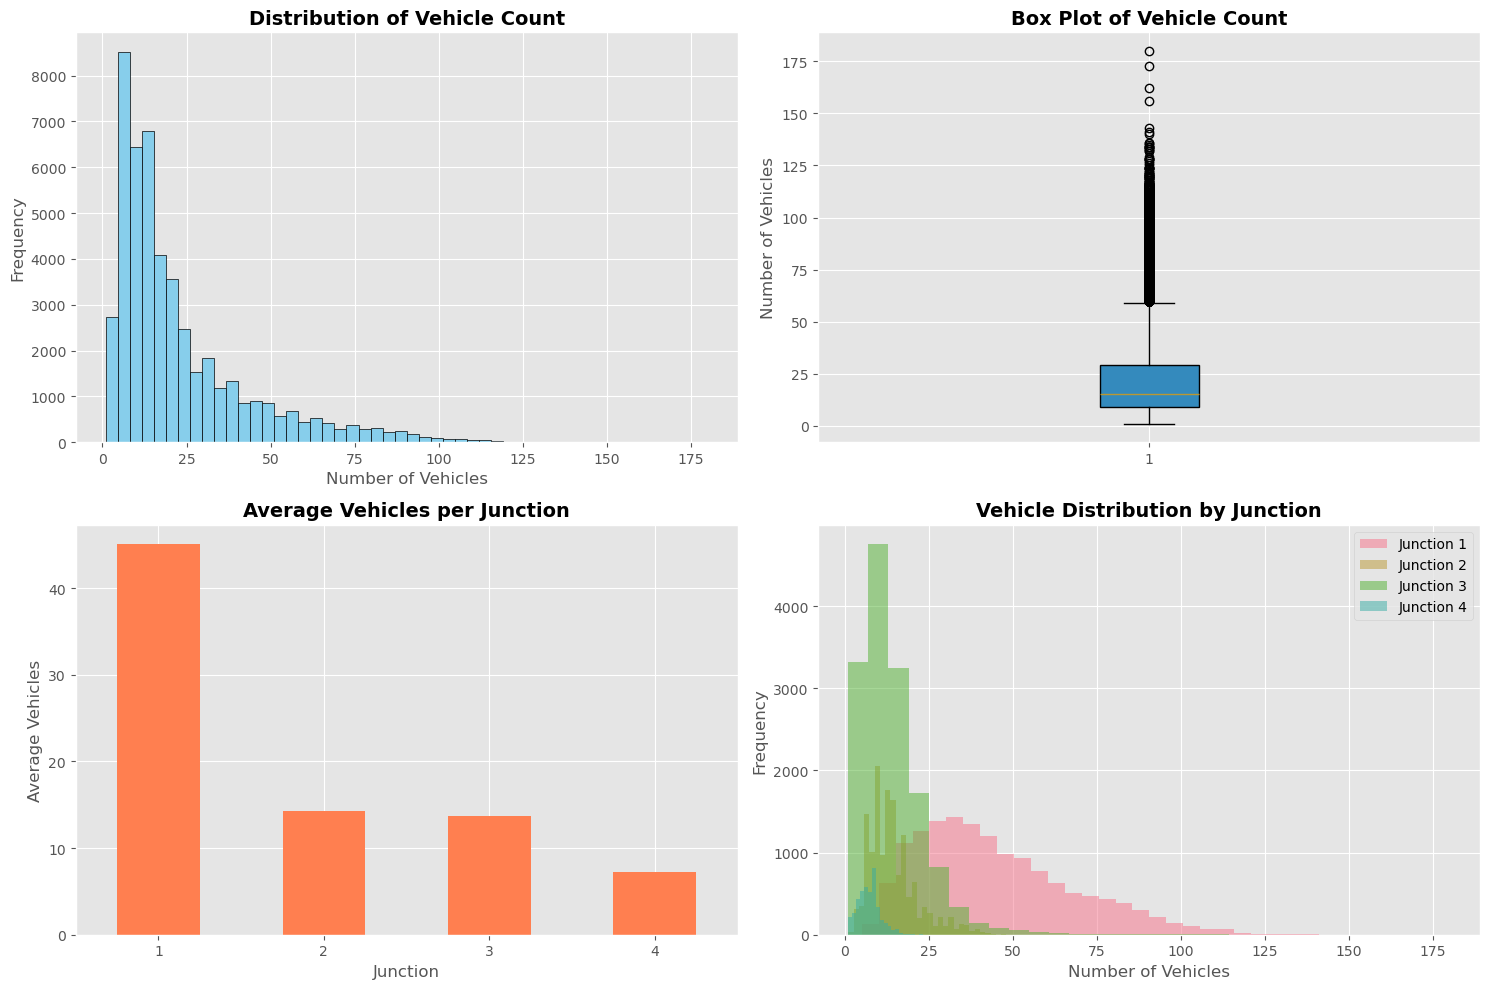

In [5]:
# Visualization 1: Distribution of Vehicles
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution of target variable
axes[0, 0].hist(df['Vehicles'], bins=50, edgecolor='black', color='skyblue')
axes[0, 0].set_title('Distribution of Vehicle Count', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Vehicles')
axes[0, 0].set_ylabel('Frequency')

# Box plot for vehicles
axes[0, 1].boxplot(df['Vehicles'], vert=True, patch_artist=True)
axes[0, 1].set_title('Box Plot of Vehicle Count', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Number of Vehicles')

# Vehicles by Junction
df.groupby('Junction')['Vehicles'].mean().plot(kind='bar', ax=axes[1, 0], color='coral')
axes[1, 0].set_title('Average Vehicles per Junction', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Junction')
axes[1, 0].set_ylabel('Average Vehicles')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=0)

# Vehicles distribution by Junction
for junction in df['Junction'].unique():
    axes[1, 1].hist(df[df['Junction'] == junction]['Vehicles'], 
                    alpha=0.5, label=f'Junction {junction}', bins=30)
axes[1, 1].set_title('Vehicle Distribution by Junction', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Vehicles')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

## 4. Feature Engineering

In [6]:
# Create a copy for feature engineering
df_processed = df.copy()

# Convert DateTime to datetime object
df_processed['DateTime'] = pd.to_datetime(df_processed['DateTime'])

# Extract time-based features
df_processed['Year'] = df_processed['DateTime'].dt.year
df_processed['Month'] = df_processed['DateTime'].dt.month
df_processed['Day'] = df_processed['DateTime'].dt.day
df_processed['Hour'] = df_processed['DateTime'].dt.hour
df_processed['DayOfWeek'] = df_processed['DateTime'].dt.dayofweek  # Monday=0, Sunday=6
df_processed['WeekOfYear'] = df_processed['DateTime'].dt.isocalendar().week
df_processed['IsWeekend'] = (df_processed['DayOfWeek'] >= 5).astype(int)

# Create time of day categories
def categorize_time(hour):
    if 6 <= hour < 12:
        return 1  # Morning
    elif 12 <= hour < 18:
        return 2  # Afternoon
    elif 18 <= hour < 22:
        return 3  # Evening
    else:
        return 4  # Night

df_processed['TimeOfDay'] = df_processed['Hour'].apply(categorize_time)

# Drop ID and DateTime as they are not useful for modeling
df_processed = df_processed.drop(['ID', 'DateTime'], axis=1)

print("Feature Engineering Complete!")
print(f"\nNew shape: {df_processed.shape}")
print("\nNew columns:")
print(df_processed.columns.tolist())
print("\nFirst few rows:")
df_processed.head()

Feature Engineering Complete!

New shape: (48120, 10)

New columns:
['Junction', 'Vehicles', 'Year', 'Month', 'Day', 'Hour', 'DayOfWeek', 'WeekOfYear', 'IsWeekend', 'TimeOfDay']

First few rows:


,Junction,Vehicles,Year,Month,Day,Hour,DayOfWeek,WeekOfYear,IsWeekend,TimeOfDay
0,1,15,2015,11,1,0,6,44,1,4
1,1,13,2015,11,1,1,6,44,1,4
2,1,10,2015,11,1,2,6,44,1,4
3,1,7,2015,11,1,3,6,44,1,4
4,1,9,2015,11,1,4,6,44,1,4


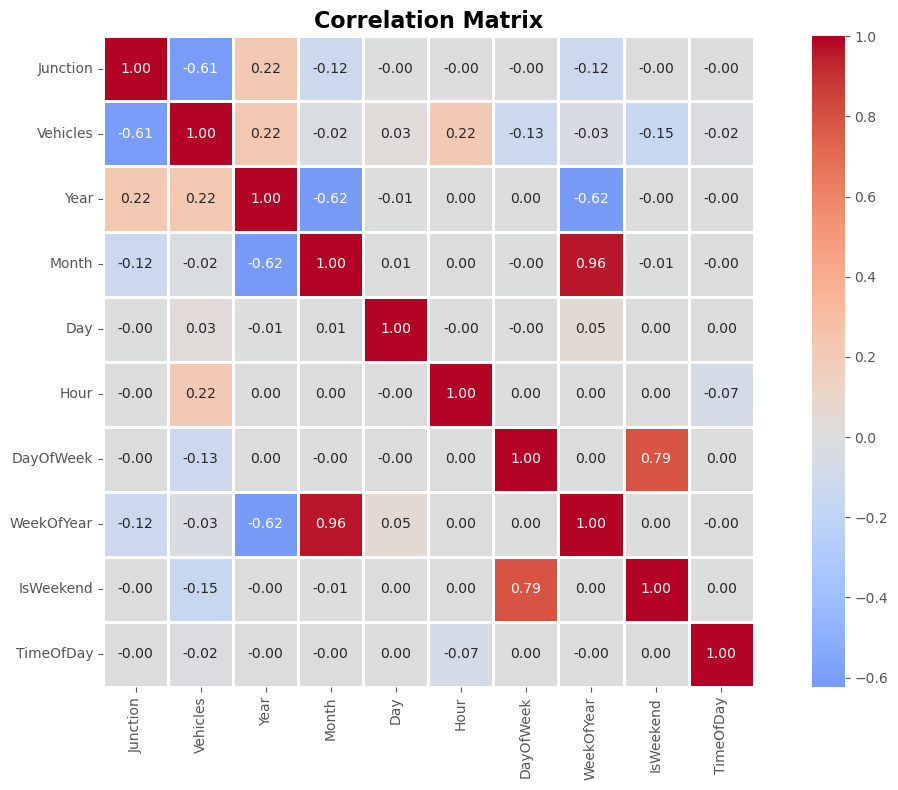


Correlation with target variable (Vehicles):
Vehicles      1.000000
Year          0.221253
Hour          0.219938
Day           0.027895
TimeOfDay    -0.020265
Month        -0.022723
WeekOfYear   -0.033747
DayOfWeek    -0.126027
IsWeekend    -0.150550
Junction     -0.613787
Name: Vehicles, dtype: float64


In [7]:
# Correlation analysis
plt.figure(figsize=(12, 8))
correlation_matrix = df_processed.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, fmt='.2f')
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nCorrelation with target variable (Vehicles):")
print(correlation_matrix['Vehicles'].sort_values(ascending=False))

## 5. Train-Test Split

In [8]:
# Separate features and target
X = df_processed.drop('Vehicles', axis=1)
y = df_processed['Vehicles']

# Split the data (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train-Test Split Complete!")
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"\nTarget variable distribution:")
print(f"Train set - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Test set - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")

Train-Test Split Complete!
Training set size: (38496, 9)
Test set size: (9624, 9)

Target variable distribution:
Train set - Mean: 22.88, Std: 20.89
Test set - Mean: 22.42, Std: 20.19


## 6. Preprocessing & Scaling

In [9]:
# Scale the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature Scaling Complete!")
print(f"Scaled training set shape: {X_train_scaled.shape}")
print(f"Scaled test set shape: {X_test_scaled.shape}")

Feature Scaling Complete!
Scaled training set shape: (38496, 9)
Scaled test set shape: (9624, 9)


## 7. Machine Learning Algorithms - Baseline Models

In [10]:
# Initialize regression models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(random_state=42),
    'Lasso Regression': Lasso(random_state=42),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'SVR': SVR(),
    'KNN': KNeighborsRegressor(),
    'XGBoost': XGBRegressor(random_state=42, verbosity=0)
}

# Function to calculate adjusted R2
def adjusted_r2(r2, n, p):
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

# Train and evaluate baseline models
results = []

print("Training baseline models...\n")
for name, model in models.items():
    print(f"Training {name}...")
    
    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test_scaled)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = adjusted_r2(r2, X_test_scaled.shape[0], X_test_scaled.shape[1])
    
    results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Adjusted R2': adj_r2
    })
    
    print(f"  R2 Score: {r2:.4f}, RMSE: {rmse:.4f}")

# Create results dataframe
results_df = pd.DataFrame(results).sort_values('R2', ascending=False)
print("\n" + "="*80)
print("BASELINE MODEL RESULTS")
print("="*80)
print(results_df.to_string(index=False))

Training baseline models...

Training Linear Regression...
  R2 Score: 0.6045, RMSE: 12.6957
Training Ridge Regression...
  R2 Score: 0.6045, RMSE: 12.6957
Training Lasso Regression...
  R2 Score: 0.5885, RMSE: 12.9497
Training Decision Tree...
  R2 Score: 0.9481, RMSE: 4.5978
Training Random Forest...
  R2 Score: 0.9692, RMSE: 3.5408
Training SVR...
  R2 Score: 0.8584, RMSE: 7.5954
Training KNN...
  R2 Score: 0.9348, RMSE: 5.1564
Training XGBoost...
  R2 Score: 0.9551, RMSE: 4.2767

BASELINE MODEL RESULTS
            Model        MSE      RMSE      MAE       R2  Adjusted R2
    Random Forest  12.536979  3.540760 2.377934 0.969238     0.969209
          XGBoost  18.290018  4.276683 2.593866 0.955122     0.955080
    Decision Tree  21.139547  4.597776 3.083229 0.948130     0.948081
              KNN  26.588096  5.156365 3.249252 0.934761     0.934700
              SVR  57.690825  7.595448 4.564022 0.858444     0.858311
 Ridge Regression 161.180802 12.695700 9.582192 0.604510     0.60413

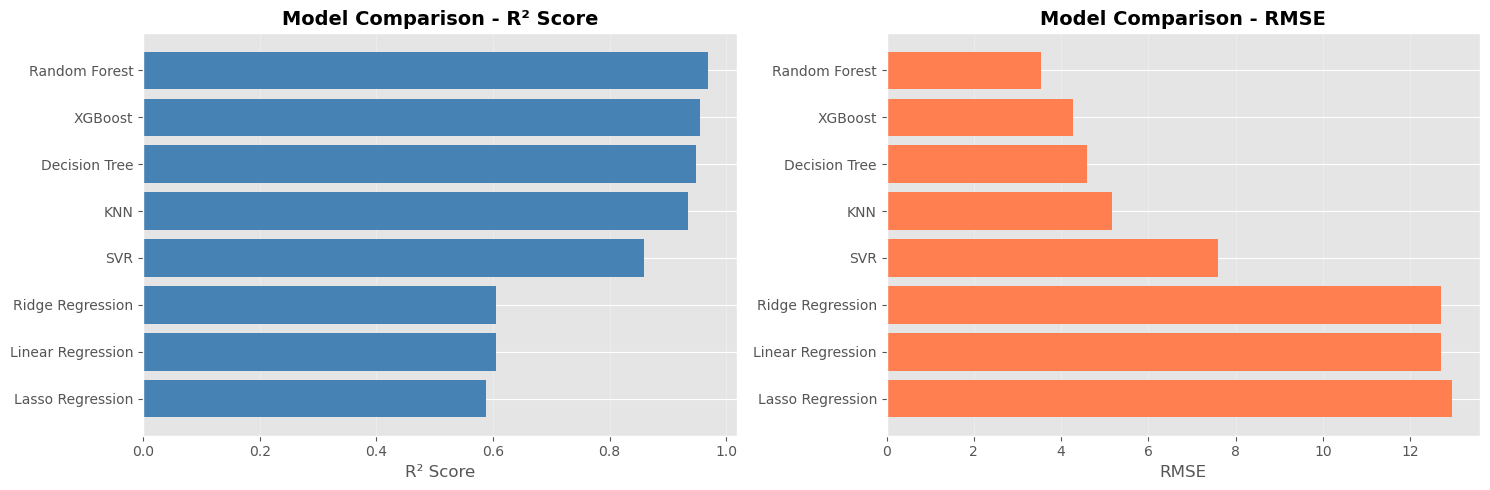

In [11]:
# Visualize baseline results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R2 Score comparison
results_df_sorted = results_df.sort_values('R2')
axes[0].barh(results_df_sorted['Model'], results_df_sorted['R2'], color='steelblue')
axes[0].set_xlabel('R² Score', fontsize=12)
axes[0].set_title('Model Comparison - R² Score', fontsize=14, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# RMSE comparison
results_df_sorted_rmse = results_df.sort_values('RMSE', ascending=False)
axes[1].barh(results_df_sorted_rmse['Model'], results_df_sorted_rmse['RMSE'], color='coral')
axes[1].set_xlabel('RMSE', fontsize=12)
axes[1].set_title('Model Comparison - RMSE', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

## 8. Hyperparameter Tuning

In [12]:
# Hyperparameter tuning for top 3 models: Random Forest, XGBoost, and Decision Tree
print("Starting Hyperparameter Tuning...\n")

# Random Forest tuning
print("Tuning Random Forest...")
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42), rf_params, 
                       cv=3, scoring='r2', n_jobs=-1, verbose=0)
rf_grid.fit(X_train_scaled, y_train)
best_rf = rf_grid.best_estimator_
print(f"Best params: {rf_grid.best_params_}")
print(f"Best CV score: {rf_grid.best_score_:.4f}")

# XGBoost tuning
print("\nTuning XGBoost...")
xgb_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01]
}
xgb_grid = GridSearchCV(XGBRegressor(random_state=42, verbosity=0), xgb_params, 
                        cv=3, scoring='r2', n_jobs=-1, verbose=0)
xgb_grid.fit(X_train_scaled, y_train)
best_xgb = xgb_grid.best_estimator_
print(f"Best params: {xgb_grid.best_params_}")
print(f"Best CV score: {xgb_grid.best_score_:.4f}")

# Decision Tree tuning
print("\nTuning Decision Tree...")
dt_params = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}
dt_grid = GridSearchCV(DecisionTreeRegressor(random_state=42), dt_params, 
                       cv=3, scoring='r2', n_jobs=-1, verbose=0)
dt_grid.fit(X_train_scaled, y_train)
best_dt = dt_grid.best_estimator_
print(f"Best params: {dt_grid.best_params_}")
print(f"Best CV score: {dt_grid.best_score_:.4f}")

print("\nHyperparameter tuning complete!")

Starting Hyperparameter Tuning...

Tuning Random Forest...
Best params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best CV score: 0.9612

Tuning XGBoost...
Best params: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}
Best CV score: 0.9551

Tuning Decision Tree...
Best params: {'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 2}
Best CV score: 0.9458

Hyperparameter tuning complete!


In [13]:
# Evaluate tuned models
tuned_results = []

tuned_models = {
    'Tuned Random Forest': best_rf,
    'Tuned XGBoost': best_xgb,
    'Tuned Decision Tree': best_dt
}

print("Evaluating tuned models...\n")
for name, model in tuned_models.items():
    y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    adj_r2 = adjusted_r2(r2, X_test_scaled.shape[0], X_test_scaled.shape[1])
    
    tuned_results.append({
        'Model': name,
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'Adjusted R2': adj_r2
    })
    
    print(f"{name}: R2={r2:.4f}, RMSE={rmse:.4f}")

tuned_results_df = pd.DataFrame(tuned_results).sort_values('R2', ascending=False)
print("\n" + "="*80)
print("TUNED MODEL RESULTS")
print("="*80)
print(tuned_results_df.to_string(index=False))

Evaluating tuned models...

Tuned Random Forest: R2=0.9694, RMSE=3.5332
Tuned XGBoost: R2=0.9588, RMSE=4.0965
Tuned Decision Tree: R2=0.9562, RMSE=4.2228

TUNED MODEL RESULTS
              Model       MSE     RMSE      MAE       R2  Adjusted R2
Tuned Random Forest 12.483349 3.533178 2.369967 0.969370     0.969341
      Tuned XGBoost 16.781361 4.096506 2.494611 0.958823     0.958785
Tuned Decision Tree 17.832385 4.222841 2.724310 0.956245     0.956204


## 9. Ensemble Techniques - Voting and Stacking

In [14]:
# Create Voting Regressor (averaging predictions)
print("Creating Voting Regressor...")
voting_reg = VotingRegressor(estimators=[
    ('rf', best_rf),
    ('xgb', best_xgb),
    ('dt', best_dt)
])

voting_reg.fit(X_train_scaled, y_train)
y_pred_voting = voting_reg.predict(X_test_scaled)

# Evaluate Voting Regressor
voting_r2 = r2_score(y_test, y_pred_voting)
voting_rmse = np.sqrt(mean_squared_error(y_test, y_pred_voting))
voting_mae = mean_absolute_error(y_test, y_pred_voting)

print(f"Voting Regressor - R2: {voting_r2:.4f}, RMSE: {voting_rmse:.4f}")

# Create Stacking Regressor
print("\nCreating Stacking Regressor...")
stacking_reg = StackingRegressor(
    estimators=[
        ('rf', best_rf),
        ('xgb', best_xgb),
        ('dt', best_dt)
    ],
    final_estimator=LinearRegression()
)

stacking_reg.fit(X_train_scaled, y_train)
y_pred_stacking = stacking_reg.predict(X_test_scaled)

# Evaluate Stacking Regressor
stacking_r2 = r2_score(y_test, y_pred_stacking)
stacking_rmse = np.sqrt(mean_squared_error(y_test, y_pred_stacking))
stacking_mae = mean_absolute_error(y_test, y_pred_stacking)

print(f"Stacking Regressor - R2: {stacking_r2:.4f}, RMSE: {stacking_rmse:.4f}")

# Store ensemble results
ensemble_results = []
ensemble_results.append({
    'Model': 'Voting Regressor',
    'MSE': mean_squared_error(y_test, y_pred_voting),
    'RMSE': voting_rmse,
    'MAE': voting_mae,
    'R2': voting_r2,
    'Adjusted R2': adjusted_r2(voting_r2, X_test_scaled.shape[0], X_test_scaled.shape[1])
})

ensemble_results.append({
    'Model': 'Stacking Regressor',
    'MSE': mean_squared_error(y_test, y_pred_stacking),
    'RMSE': stacking_rmse,
    'MAE': stacking_mae,
    'R2': stacking_r2,
    'Adjusted R2': adjusted_r2(stacking_r2, X_test_scaled.shape[0], X_test_scaled.shape[1])
})

ensemble_results_df = pd.DataFrame(ensemble_results)
print("\n" + "="*80)
print("ENSEMBLE MODEL RESULTS")
print("="*80)
print(ensemble_results_df.to_string(index=False))

Creating Voting Regressor...
Voting Regressor - R2: 0.9684, RMSE: 3.5870

Creating Stacking Regressor...
Stacking Regressor - R2: 0.9704, RMSE: 3.4726

ENSEMBLE MODEL RESULTS
             Model       MSE     RMSE      MAE       R2  Adjusted R2
  Voting Regressor 12.866502 3.586991 2.331438 0.968429     0.968400
Stacking Regressor 12.059064 3.472616 2.280201 0.970411     0.970383


## 10. Comparative Analysis - All Models

In [15]:
# Combine all results
all_results = pd.concat([results_df, tuned_results_df, ensemble_results_df], ignore_index=True)
all_results_sorted = all_results.sort_values('R2', ascending=False)

print("="*100)
print("COMPREHENSIVE MODEL COMPARISON - ALL MODELS")
print("="*100)
print(all_results_sorted.to_string(index=False))

# Identify best model
best_model_name = all_results_sorted.iloc[0]['Model']
best_model_r2 = all_results_sorted.iloc[0]['R2']
best_model_rmse = all_results_sorted.iloc[0]['RMSE']

print("\n" + "="*100)
print(f"🏆 BEST MODEL: {best_model_name}")
print(f"   R² Score: {best_model_r2:.4f}")
print(f"   RMSE: {best_model_rmse:.4f}")
print("="*100)

COMPREHENSIVE MODEL COMPARISON - ALL MODELS
              Model        MSE      RMSE      MAE       R2  Adjusted R2
 Stacking Regressor  12.059064  3.472616 2.280201 0.970411     0.970383
Tuned Random Forest  12.483349  3.533178 2.369967 0.969370     0.969341
      Random Forest  12.536979  3.540760 2.377934 0.969238     0.969209
   Voting Regressor  12.866502  3.586991 2.331438 0.968429     0.968400
      Tuned XGBoost  16.781361  4.096506 2.494611 0.958823     0.958785
Tuned Decision Tree  17.832385  4.222841 2.724310 0.956245     0.956204
            XGBoost  18.290018  4.276683 2.593866 0.955122     0.955080
      Decision Tree  21.139547  4.597776 3.083229 0.948130     0.948081
                KNN  26.588096  5.156365 3.249252 0.934761     0.934700
                SVR  57.690825  7.595448 4.564022 0.858444     0.858311
   Ridge Regression 161.180802 12.695700 9.582192 0.604510     0.604139
  Linear Regression 161.181692 12.695735 9.582310 0.604507     0.604137
   Lasso Regression 

## 11. Model Evaluation - Best Model Analysis

In [17]:
# Detailed evaluation of the best model (Stacking Regressor)
print("="*80)
print("DETAILED EVALUATION - STACKING REGRESSOR (BEST MODEL)")
print("="*80)

# Predictions
y_pred_best = stacking_reg.predict(X_test_scaled)

# Calculate all metrics
mse_best = mean_squared_error(y_test, y_pred_best)
rmse_best = np.sqrt(mse_best)
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)
adj_r2_best = adjusted_r2(r2_best, X_test_scaled.shape[0], X_test_scaled.shape[1])

print(f"\nRegression Metrics:")
print(f"  • Mean Squared Error (MSE):     {mse_best:.4f}")
print(f"  • Root Mean Squared Error (RMSE): {rmse_best:.4f}")
print(f"  • Mean Absolute Error (MAE):    {mae_best:.4f}")
print(f"  • R² Score:                     {r2_best:.4f}")
print(f"  • Adjusted R² Score:            {adj_r2_best:.4f}")

# Error analysis
errors = y_test - y_pred_best
print(f"\nError Analysis:")
print(f"  • Mean Error:                   {errors.mean():.4f}")
print(f"  • Std of Errors:                {errors.std():.4f}")
print(f"  • Min Error:                    {errors.min():.4f}")
print(f"  • Max Error:                    {errors.max():.4f}")

# Prediction accuracy within ranges
within_1 = np.sum(np.abs(errors) <= 1) / len(errors) * 100
within_3 = np.sum(np.abs(errors) <= 3) / len(errors) * 100
within_5 = np.sum(np.abs(errors) <= 5) / len(errors) * 100

print(f"\nPrediction Accuracy:")
print(f"  • Within ±1 vehicle:  {within_1:.2f}%")
print(f"  • Within ±3 vehicles: {within_3:.2f}%")
print(f"  • Within ±5 vehicles: {within_5:.2f}%")
print("="*80)

DETAILED EVALUATION - STACKING REGRESSOR (BEST MODEL)

Regression Metrics:
  • Mean Squared Error (MSE):     12.0591
  • Root Mean Squared Error (RMSE): 3.4726
  • Mean Absolute Error (MAE):    2.2802
  • R² Score:                     0.9704
  • Adjusted R² Score:            0.9704

Error Analysis:
  • Mean Error:                   -0.0377
  • Std of Errors:                3.4726
  • Min Error:                    -38.3712
  • Max Error:                    58.0383

Prediction Accuracy:
  • Within ±1 vehicle:  30.33%
  • Within ±3 vehicles: 75.08%
  • Within ±5 vehicles: 92.00%


## 12. Final Summary & Conclusions

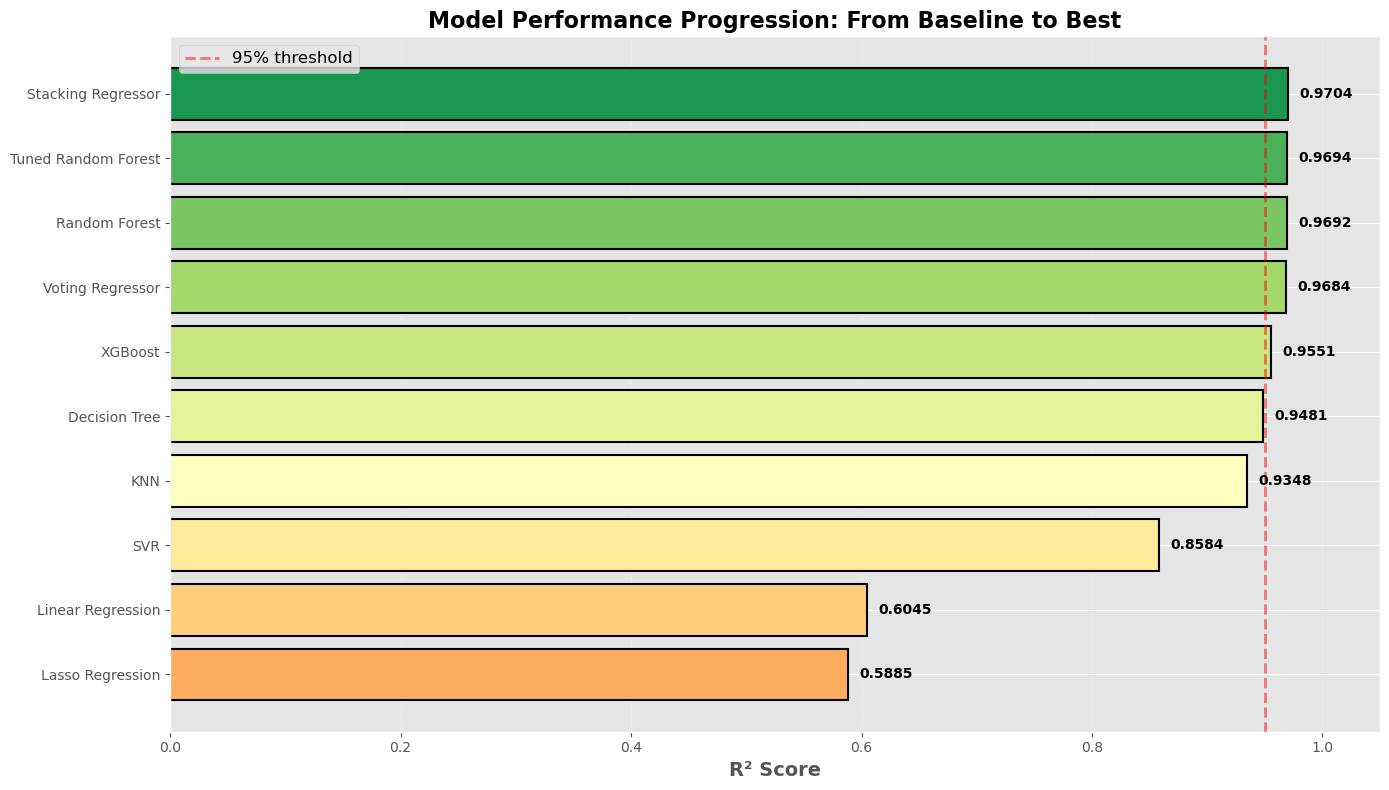

In [23]:
# Final visualization - Model progression
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

# Select key models to show progression
progression_models = [
    'Linear Regression',
    'Lasso Regression', 
    'SVR',
    'KNN',
    'Decision Tree',
    'XGBoost',
    'Random Forest',
    'Tuned Random Forest',
    'Voting Regressor',
    'Stacking Regressor'
]

# Filter and sort by progression
prog_data = all_results_sorted[all_results_sorted['Model'].isin(progression_models)].copy()
prog_data = prog_data.sort_values('R2')

# Create color gradient
colors = plt.cm.RdYlGn(np.linspace(0.3, 0.9, len(prog_data)))

bars = ax.barh(prog_data['Model'], prog_data['R2'], color=colors, edgecolor='black', linewidth=1.5)

# Add value labels on bars
for i, (bar, r2_val) in enumerate(zip(bars, prog_data['R2'])):
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{r2_val:.4f}',
            ha='left', va='center', fontweight='bold', fontsize=10)

ax.set_xlabel('R² Score', fontsize=14, fontweight='bold')
ax.set_title('Model Performance Progression: From Baseline to Best', fontsize=16, fontweight='bold')
ax.set_xlim(0, 1.05)
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.axvline(x=0.95, color='red', linestyle='--', linewidth=2, alpha=0.5, label='95% threshold')
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()
